## *Background*

At the heart of the modern LLM boom is the transformer model architecture.
Fundamentally, transformers are tools designed to accurately predict the next word that will occur after any given sequence of prior words.
They accomplish this by converting words into high-dimensional vectors and then performing a series of matrix operations on them, the internal parameters of which are iteratively tweaked such that the last vector at the end of these operations corresponds to a ranked superposition of potential next words.


![3b1b_wordsasvec](https://3b1b-posts.us-east-1.linodeobjects.com/content/lessons/2024/gpt/token.png)
Figure 1: Words represented as vectors in a transformer model. Credit to [3Blue1Brown](https://www.3blue1brown.com/lessons/gpt) for image.


These iterative operations are organized as layers.
Conceptually, each layer should tweak its internal weights so that it embeds additional information about what the predicted word should be into the sequence of vectors flowing through the transformer.
After passing through each layer, the vector for the predicted word should be iteratively transformed into a vector that will produce a high-quality prediction.


![3b1b_layers](https://3b1b-posts.us-east-1.linodeobjects.com/content/lessons/2024/gpt/arrays.png)
Figure 2: Sequences of vectors passing through layers of a transformer model. Credit to [3Blue1Brown](https://www.3blue1brown.com/lessons/gpt) for image.


[comment]: <> (this is a good point to include lit review)
Observing the state of these internal vectors after each layer, their *transformation*, may provide some insight on the information injected into the vectors by each layer.
However, such information is not guaranteed to be human interpretable.
A common example is that of the vectors corresponding to the words "king", "queen", "man", and "woman".
At a high level, transformers learn to relate these concepts as "king" - "man" + "woman" = "queen".
Interpretability of this sort is rare in practice, and transformers tend to relate words and concepts in ways that do not have human counterparts.
To avoid this pitfall, the transformation of inputs belonging to different sets of data can be compared to each other instead, enabling a "coordinate-free" method of analysis.

In this work, I utilize a comparative technique to isolate distinct transformative paths of factual and hallucinated LLM outputs, with a goal of developing a monitoring technique to flag hallucinations before they are shown to a user.
A robust methodology to monitor hallucinated outputs would reduce the risk of unsafe misinformation dissemination and lay the groundwork for monitoring other adverse LLM outputs, like deception and power-seeking behavior.

## *Data & Methodology*

### Datasets
Assessing whether an LLM output is a hallucination is not a trivial task in most circumstances.
In order to guarantee that data are labelled accurately, I limited the scope of this project to simple math problems.
I generated two datasets of addition problems: one comprised of outputs where the LLM correctly solves the problem and one where it does not.

All LLM inputs are of the form
```
The sum of 1 and {num} equals
```
The `num` variable ranges from 1 to 9999.
Since transformers output one token at a time, and each token is a single digit number, the quantity of data points can be increased by generating them recursively.
For example, the input
```
The sum of 1 and 12 equals
```
will produce `1` first, leading to
```
The sum of 1 and 12 equals 1
```
which leads to `3` for the next token. Both of these outputs are a unique data point. If the prediction is correct, the data point is binned in the "Factual" dataset, and in the "Hallucination" dataset if not.
There is significant class imbalance between the two, with the Factual dataset containing 38727 records and the Hallucination dataset containing 166 records.

### Model
To remain within computational limitations, I used the Qwen3 4 billion parameter base model and its associated tokenizer.
Due to its small size, it is worth noting that hallucinations will be more common than flagship models, even for simple math.

### Tracing Transformative Paths
Cosine similarity is a popular measure of similarity between two vectors.
Two vectors pointing in the same direction will have a cosine similarity value of +1 or -1 if they point in the exact opposite directions.
A value of 0 indicates the two vectors point in direction orthogonal to each other.


![cosine_similarity](https://storage.googleapis.com/lds-media/images/cosine-similarity-vectors.width-745.jpg)

Figure 3: The range of values possible for cosine similarity between two vectors. Credit to [LearnDataSci](https://www.learndatasci.com/glossary/cosine-similarity/) for image.


Of all the hidden vectors, the last one in the last hidden state is of particular importance:
It is the only vector that is ultimately converted back to a token.
As such, it is an obvious candidate for tracing similarity throughout layers.
For each data record, I compare the cosine similarity of the last vector of each hidden state to the last vector of the prior hidden state.
Aggregating cosine similarity values across each dataset produces trends common across all addition problems represented in the data.

## *Results*

![cosine_similarity](https://drive.google.com/uc?export=view&id=1g90G_aMoe0nnza9WmVEouA0_oMBnHh58)

Figure 4: Transformative path of the last vector of each hidden state throughout the layers of a transformer. Comparisons are made between the output of layer $t$ and $t-1$. The trend labelled "correct" corresponds to the Factual dataset and the trend labelled "incorrect" corresponds to the Hallucination dataset. Medians for each bin are shown as dots and 16th and 84th percentiles are shown with a bar and endcap.


As seen in Figure 4, there are clear indicators that the Factual data presents as a different trend than the Hallucination data.
The distributions at some bins are visibly distinct, with different medians and 16th/84th percentile values.


## *Discussion*

The preliminary result in Figure 4 shows that there is potential with this technique for identifying hallucinations before they are presented to a user.
Automated classification of hallucinations would enable deployment of this analysis technique in real-world use cases.

For example, each dataset in this work could be used to build a corresponding KDE function.
When a new summation generation is requested, a routine could track the transformative path of the hidden vectors and assess the probability of the new data point falling in the Factual and Hallucination probability distributions.
By comparing these probabilities with each other at each layer output and aggregating the results, a "probability of hallucination" can be estimated.
If this probability is above a predefined threshold, the response can be flagged to the user as having a high likelihood of containing inaccurate information or the new token can be regenerated.

The KDE estimation method could also be applied at the pretraining stage of LLM development.
If the technique described in this work can be extended beyond addition problem to any possible input, the probability of hallucination of a new token can be used as an auxillary optimization function.
While learning to predict the next word, a LLM could also learn to make sure the new word is factually correct.

For this auxillary optimization to work however, and to make these results more usable in general, this work needs to be extended to natural language situations.
Building hallucination vs. factual datasets becomes more difficult in this case, since unlike math problems, which have a defined correct/incorrect answer, natural language is often more ambiguous.
A preliminary step could be to build datasets of completions that will have a definite correct answer.
For example, the completion
```
The capital city of France is
```
has a well-defined correct answer of `Paris`.

Another necessary step in generalizing these results is to analyze transformative paths in different models.
This work uses a Qwen3 base model, which are not the LLMs consumers interact with on sites like ChatGPT.
Those have been fine tuned beyond their pretraining and so they may have weights that lead to different transformative paths than those seen in base models.
Consumer grade LLMs are also much larger than the 4 billion parameter model used here.
Both of these shortcomings are straightforward to address with additional computational resources.

## *Appendix A: Dataset creation and analysis*

In [ ]:
%%capture
!pip install -U transformers
!pip install --upgrade torch
!pip install kernels
!pip install torchinfo

In [ ]:
from transformers import AutoModelForCausalLM, AutoTokenizer
import torch
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import torchinfo
import random

In [ ]:
import os
from google.colab import drive
drive.mount('drive')

Drive already mounted at drive; to attempt to forcibly remount, call drive.mount("drive", force_remount=True).


In [ ]:
!ls "drive/MyDrive/AISES Course/Research Project"

correct_data_max9999_prevsims_lastvec.pkl    result0.png
incorrect_data_max9999_prevsims_lastvec.pkl


In [ ]:
model_id = "Qwen/Qwen3-4B-Base"

torch.no_grad()
model = AutoModelForCausalLM.from_pretrained(model_id,
                                             device_map='cuda',
                                             torch_dtype='auto')
tokenizer = AutoTokenizer.from_pretrained(model_id)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/727 [00:00<?, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!


model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/99.6M [00:00<?, ?B/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/3.99G [00:00<?, ?B/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/3.96G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/138 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

In [16]:
def get_next_token(hidden_states, model, tokenizer):
  target_tensor = hidden_states[-1].squeeze()[-1]
  target_logits = model.lm_head(target_tensor)
  return tokenizer.decode(target_logits.argmax(dim=-1))

def generate_cos_sims_for_token(message, model, tokenizer,
                                vector_pos=-1, comp='prev'):
  inputs = tokenizer(message, return_tensors="pt").to(model.device)
  generated = model(**inputs, max_new_tokens=1, output_hidden_states=True)
  predicted_token = get_next_token(generated.hidden_states, model, tokenizer)
  if vector_pos == 'all':
    # this functionality does not work as of rn
    cos_sims = []
    for row in range(generated.hidden_states[0].squeeze().shape[0]):
      cos_sims.append(torch.tensor(np.array(calc_sims(generated.hidden_states, vector_pos=row, comp=comp))))
    cos_sims = torch.stack(cos_sims)
  else:
    cos_sims = calc_sims(generated.hidden_states, vector_pos, comp)
  return predicted_token, cos_sims

def calc_sims(hidden_states, vector_pos=-1, comp='prev'):
  if comp == 'prev':
    prev_target_tensor = hidden_states[0].squeeze(0)[vector_pos]
  elif comp == 'first':
    # using 1 as the index below since that's the one after the first
    # transformer layer
    # 0 is right after vocab dim to embedding dim
    prev_target_tensor = hidden_states[1].squeeze(0)[vector_pos]
  elif comp == 'last':
    # -2 below because -1 corresponds to embeddings after RMSNorm i think
    # hard to tell for sure, but the differential cos_sim jumps a lot there
    prev_target_tensor = hidden_states[-2].squeeze(0)[vector_pos]
  sim_func = torch.nn.CosineSimilarity(dim=-1, eps=1e-6)
  cos_sims = []
  for hidden_state in hidden_states[1:]:
    target_tensor = hidden_state.squeeze(0)[vector_pos]
    cos_sim = sim_func(target_tensor, prev_target_tensor)
    cos_sims.append(cos_sim.cpu().detach().float().numpy())
    if comp == 'prev':
      prev_target_tensor = target_tensor
  # removing the first and last entries here because of the reasons outlined
  # in the IF statement in the beginning of this function
  return cos_sims[1:-1]

def standardize(x):
  return (x - x.mean()) / x.std()

def get_statistics(x, axis=0):
  # x is an np array
  return {'mean': np.mean(x, axis=axis),
          'median': np.median(x, axis=axis),
          'std': np.std(x, axis=axis, ddof=1),
          'min': np.min(x, axis=axis),
          'max': np.max(x, axis=axis),
          'p16': np.percentile(x, 16, axis=axis),
          'p84': np.percentile(x, 84, axis=axis),
          'shape': x.shape
          }

In [ ]:
def generate_num_dataset(num_samples, start_num, max_num, model, tokenizer):
  samples_done = 0
  correct_cos_sims = []
  incorrect_cos_sims = []
  while samples_done < num_samples:
    first_integer = random.randint(start_num, max_num)
    second_integer = random.randint(start_num, max_num)
    base_message = f'The sum of {first_integer} and {second_integer} equals '
    true_sum = first_integer + second_integer
    # maybe its better to just pick a random i
    for i in range(len(str(true_sum))):
      beginning_digits = str(true_sum)[:i]
      message = base_message + beginning_digits
      true_label = str(true_sum)[i]
      predicted_token, cos_sims = generate_cos_sims_for_token(message, model, tokenizer)
      if predicted_token == true_label:
        correct_cos_sims.append(cos_sims)
      else:
        incorrect_cos_sims.append(cos_sims)
      samples_done += 1
      if samples_done % 100 == 0:
        print(f'Samples done: {samples_done}/{num_samples}')
        print(f'Correct samples: {len(correct_cos_sims)}')
        print(f'Incorrect samples: {len(incorrect_cos_sims)}')
  return np.array(correct_cos_sims), np.array(incorrect_cos_sims)

In [ ]:
correct_data, incorrect_data = generate_num_dataset(25000, int(1e2), int(1e7),
                                                    model, tokenizer)

# import pickle
# with open('drive/MyDrive/AISES Course/Research Project/20250910_correct.pkl', 'wb') as f:
#   pickle.dump(correct_data, f)
# print('Saved correct data')
# with open('drive/MyDrive/AISES Course/Research Project/20250910_incorrect.pkl', 'wb') as f:
#   pickle.dump(incorrect_data, f)
# print('Saved incorrect data')
# from google.colab import runtime
# runtime.unassign()

Samples done: 100/25000
Correct samples: 99
Incorrect samples: 1
Samples done: 200/25000
Correct samples: 196
Incorrect samples: 4
Samples done: 300/25000
Correct samples: 296
Incorrect samples: 4
Samples done: 400/25000
Correct samples: 394
Incorrect samples: 6
Samples done: 500/25000
Correct samples: 494
Incorrect samples: 6
Samples done: 600/25000
Correct samples: 592
Incorrect samples: 8
Samples done: 700/25000
Correct samples: 689
Incorrect samples: 11
Samples done: 800/25000
Correct samples: 788
Incorrect samples: 12
Samples done: 900/25000
Correct samples: 887
Incorrect samples: 13
Samples done: 1000/25000
Correct samples: 987
Incorrect samples: 13
Samples done: 1100/25000
Correct samples: 1083
Incorrect samples: 17
Samples done: 1200/25000
Correct samples: 1182
Incorrect samples: 18
Samples done: 1300/25000
Correct samples: 1278
Incorrect samples: 22
Samples done: 1400/25000
Correct samples: 1376
Incorrect samples: 24
Samples done: 1500/25000
Correct samples: 1475
Incorrect sam

In [18]:
print(f'There are {correct_data['count']} correct predictions and {incorrect_data['count']} incorrect predictions.')

plt.errorbar(range(len(correct_data['median'])), correct_data['median'],
             yerr=np.array([correct_data['median'] - correct_data['16th'], correct_data['84th'] - correct_data['median']]),
             marker='o', label='correct', capsize=4)

plt.errorbar(range(len(incorrect_data['median'])), incorrect_data['median'],
             yerr=np.array([incorrect_data['median'] - incorrect_data['16th'], incorrect_data['84th'] - incorrect_data['median']]),
             marker='o', label='incorrect', capsize=4)

plt.xlabel('Layer')
plt.ylabel('Cosine Similarity')
plt.legend()
plt.title('Embedding at Layer t Relative to Layer t-1')
plt.show()

SyntaxError: f-string: unmatched '[' (1284136252.py, line 1)

## *Appendix B: Classification tests*

In [1]:
from scipy.stats import gaussian_kde, ks_2samp
from scipy.special import softmax
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
import random

In [3]:
import os
from google.colab import drive
drive.mount('drive')

Drive already mounted at drive; to attempt to forcibly remount, call drive.mount("drive", force_remount=True).


In [2]:
local_path_correct = '20250910_correct.pkl'
local_path_incorrect = '20250910_incorrect.pkl'

drive_path_correct = 'drive/MyDrive/AISES Course/Research Project/' + local_path_correct    
drive_path_incorrect = 'drive/MyDrive/AISES Course/Research Project/' + local_path_incorrect

correct_data = np.load(local_path_correct, allow_pickle=True)
incorrect_data = np.load(local_path_incorrect, allow_pickle=True)
print(f'Num. of correct records: {correct_data.shape[0]}')
print(f'Num. of incorrect records: {incorrect_data.shape[0]}')
train_correct, test_correct = train_test_split(correct_data, test_size=0.2)
train_incorrect, test_incorrect = train_test_split(incorrect_data, test_size=0.2)
print(f'Num. of correct training records: {train_correct.shape[0]}')
print(f'Num. of correct testing records: {test_correct.shape[0]}')
print(f'Num. of incorrect training records: {train_incorrect.shape[0]}')
print(f'Num. of incorrect testing records: {test_incorrect.shape[0]}')

Num. of correct records: 24640
Num. of incorrect records: 363
Num. of correct training records: 19712
Num. of correct testing records: 4928
Num. of incorrect training records: 290
Num. of incorrect testing records: 73


In [3]:
# check if sampling from correct data will produce stat. diff. dists.
resample_count = 10
total_diff_count = 0
for i in range(correct_data.shape[1]):
  # print(f'Layer {i+1} of {correct_data.shape[1]}')
  diff_count = 0
  layer_data = train_correct[:, i]
  for j in range(resample_count):
    sample_1 = np.random.choice(layer_data, size=train_incorrect.shape[0])
    sample_2 = np.random.choice(layer_data, size=train_incorrect.shape[0])
    ks_pvalue = ks_2samp(sample_1, sample_2).pvalue
    if ks_pvalue < 0.05:
      diff_count += 1
      total_diff_count += 1
  # print(f'{diff_count} of {resample_count} samples had statistically different distributions.')
print(f'{total_diff_count} of {resample_count*correct_data.shape[1]} ' + \
  'resampled distributions were statistically different when data was sampled from the correct data.')

7 of 340 resampled distributions were statistically different when data was sampled from the correct data.


In [4]:
correct_kdes = {}
incorrect_kdes = {}
comparison_pvalues = {}
bandwidths = 10 ** np.linspace(-2, -1, 50)
for i in range(correct_data.shape[1]):
  print(f'Layer {i+1} of {correct_data.shape[1]}')
  ks_pvalue = ks_2samp(train_correct[:, i], train_incorrect[:, i]).pvalue
  comparison_pvalues[i] = ks_pvalue
  if ks_pvalue < 0.05:
    # correct_kdes[i] = gaussian_kde(train_correct[:, i], bw_method='silverman')
    # incorrect_kdes[i] = gaussian_kde(train_incorrect[:, i], bw_method='silverman')
    kde_search = GridSearchCV(KernelDensity(kernel='gaussian'), {'bandwidth': bandwidths}, 
                              cv=3, n_jobs=-1, verbose=2)
    kde_search.fit(train_correct[:, i][:, None])
    correct_kdes[i] = kde_search.best_estimator_
    kde_search.fit(train_incorrect[:, i][:, None])
    incorrect_kdes[i] = kde_search.best_estimator_
    clear_output(wait=True)
print(f'There are {len(correct_kdes)} layers where correct training data was statistically different from incorrect data.')
stat_diff_layers = list(correct_kdes.keys())

There are 16 layers where correct training data was statistically different from incorrect data.


In [5]:
def get_statistics(x, axis=0):
  # x is an np array
  return {'mean': np.mean(x, axis=axis),
          'median': np.median(x, axis=axis),
          'std': np.std(x, axis=axis, ddof=1),
          'min': np.min(x, axis=axis),
          'max': np.max(x, axis=axis),
          'p16': np.percentile(x, 16, axis=axis),
          'p84': np.percentile(x, 84, axis=axis),
          'shape': x.shape
          }
correct_train_stats = get_statistics(train_correct, axis=0)
incorrect_train_stats = get_statistics(train_incorrect, axis=0)

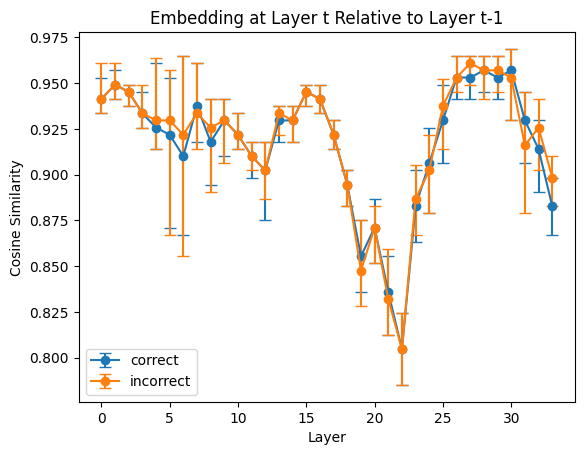

In [7]:
plt.errorbar(range(correct_train_stats['shape'][1]), correct_train_stats['median'],
             yerr=np.array([correct_train_stats['median'] - correct_train_stats['p16'], correct_train_stats['p84'] - correct_train_stats['median']]),
             marker='o', label='correct', capsize=4)
plt.errorbar(range(incorrect_train_stats['shape'][1]), incorrect_train_stats['median'],
             yerr=np.array([incorrect_train_stats['median'] - incorrect_train_stats['p16'], incorrect_train_stats['p84'] - incorrect_train_stats['median']]),
             marker='o', label='incorrect', capsize=4)
plt.xlabel('Layer')
plt.ylabel('Cosine Similarity')
plt.legend()
plt.title('Embedding at Layer t Relative to Layer t-1')
plt.show()

0.00041512290136138004


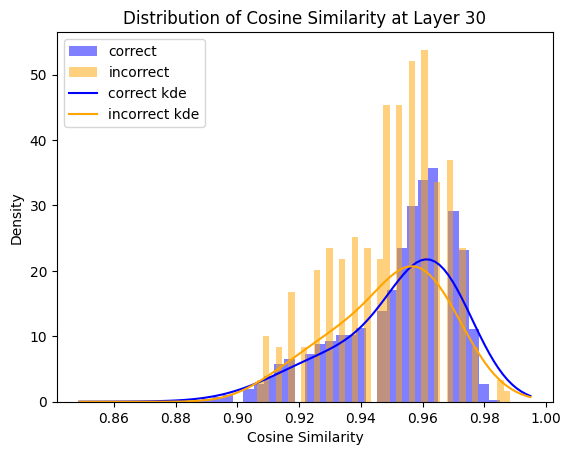

In [8]:
layer_num = stat_diff_layers[13]
plt.hist(train_correct[:, layer_num], bins=40, density=True, alpha=0.5, 
         label='correct', color='blue')
plt.hist(train_incorrect[:, layer_num], bins=40, density=True, alpha=0.5, 
         label='incorrect', color='orange')
# plt.vlines(x=correct_train_stats['median'][layer_num], ymin=0, ymax=plt.ylim()[1], color='blue', linestyle='--')
# plt.vlines(x=incorrect_train_stats['median'][layer_num], ymin=0, ymax=plt.ylim()[1], color='orange', linestyle='--')
x_eval = np.linspace(plt.xlim()[0], plt.xlim()[1], 100)
plt.plot(x_eval, np.exp(correct_kdes[layer_num].score_samples(x_eval[:, None])), 
         label='correct kde', color='blue')
plt.plot(x_eval, np.exp(incorrect_kdes[layer_num].score_samples(x_eval[:, None])), 
         label='incorrect kde', color='orange')
plt.xlabel('Cosine Similarity')
plt.ylabel('Density')
plt.title(f'Distribution of Cosine Similarity at Layer {layer_num}')
plt.legend()
print(ks_2samp(train_correct[:, layer_num], train_incorrect[:, layer_num]).pvalue)

In [47]:
# frequentist approach
true_neg = 0
for record in test_correct:
  correct_prob = 1.
  incorrect_prob = 1.
  for i in correct_kdes.keys():
    correct_prob = correct_prob * correct_kdes[i](record[i])
    incorrect_prob = incorrect_prob * incorrect_kdes[i](record[i])
  if correct_prob > incorrect_prob:
    true_neg += 1
true_pos = 0
for record in test_incorrect:
  correct_prob = 1.
  incorrect_prob = 1.
  for i in correct_kdes.keys():
    correct_prob = correct_prob * correct_kdes[i](record[i])
    incorrect_prob = incorrect_prob * incorrect_kdes[i](record[i])
  if incorrect_prob > correct_prob:
    true_pos += 1

TypeError: 'KernelDensity' object is not callable

In [ ]:
# bayesian approach

class_prob_incorrect = train_incorrect.shape[0] / (train_correct.shape[0] + train_incorrect.shape[0])
class_prob_correct = 1 - class_prob_incorrect

true_pos = 0
for i, record in enumerate(test_incorrect):
  prior_incorrect = class_prob_incorrect
  prior_correct = class_prob_correct
  for layer in stat_diff_layers:
    x = record[layer].reshape(1, -1)
    incorrect_density = np.exp(incorrect_kdes[layer].score(x)) 
    correct_density = np.exp(correct_kdes[layer].score(x))
    incorrect_numer = incorrect_density * prior_incorrect
    correct_numer = correct_density * prior_correct
    denom = incorrect_density * prior_incorrect + correct_density * prior_correct
    prior_incorrect = incorrect_numer / denom
    prior_correct = correct_numer / denom
  if prior_incorrect > prior_correct:
    true_pos += 1
  if i % 100 == 0:
    print(f'Records done: {i+1}/{test_incorrect.shape[0]}')
print(f'Records done: {i+1}/{test_incorrect.shape[0]}')

true_neg = 0
for i, record in enumerate(test_correct):
  prior_incorrect = class_prob_incorrect
  prior_correct = class_prob_correct
  for layer in stat_diff_layers:
    x = record[layer].reshape(1, -1)
    incorrect_density = np.exp(incorrect_kdes[layer].score(x))  
    correct_density = np.exp(correct_kdes[layer].score(x))
    incorrect_numer = incorrect_density * prior_incorrect
    correct_numer = correct_density * prior_correct
    denom = incorrect_density * prior_incorrect + correct_density * prior_correct
    prior_incorrect = incorrect_numer / denom
    prior_correct = correct_numer / denom
  if prior_correct > prior_incorrect:
    true_neg += 1
  if i % 100 == 0:
    print(f'Records done: {i+1}/{test_correct.shape[0]}')
print(f'Records done: {i+1}/{test_correct.shape[0]}')

Records done: 1/73
Records done: 73/73
Records done: 1/4928
Records done: 101/4928
Records done: 201/4928
Records done: 301/4928
Records done: 401/4928
Records done: 501/4928
Records done: 601/4928
Records done: 701/4928
Records done: 801/4928
Records done: 901/4928
Records done: 1001/4928
Records done: 1101/4928
Records done: 1201/4928
Records done: 1301/4928
Records done: 1401/4928
Records done: 1501/4928
Records done: 1601/4928
Records done: 1701/4928
Records done: 1801/4928
Records done: 1901/4928
Records done: 2001/4928
Records done: 2101/4928
Records done: 2201/4928
Records done: 2301/4928
Records done: 2401/4928
Records done: 2501/4928
Records done: 2601/4928
Records done: 2701/4928
Records done: 2801/4928
Records done: 2901/4928
Records done: 3001/4928
Records done: 3101/4928
Records done: 3201/4928
Records done: 3301/4928
Records done: 3401/4928
Records done: 3501/4928
Records done: 3601/4928
Records done: 3701/4928
Records done: 3801/4928
Records done: 3901/4928
Records done:

In [ ]:
# frequentist approach

true_pos = 0
for i, record in enumerate(test_incorrect):
    total_incorrect_density = 0
    total_correct_density = 0        
    for layer in stat_diff_layers:
        x = record[layer].reshape(1, -1)
        incorrect_density = incorrect_kdes[layer].score(x)
        correct_density = correct_kdes[layer].score(x)
        total_incorrect_density += incorrect_density
        total_correct_density += correct_density
    if total_incorrect_density > total_correct_density:
        true_pos += 1
    if i % 100 == 0:
        print(f'Records done: {i+1}/{test_incorrect.shape[0]}')
print(f'Records done: {i+1}/{test_incorrect.shape[0]}')

true_neg = 0
for i, record in enumerate(test_correct):
    total_incorrect_density = 0
    total_correct_density = 0         
    for layer in stat_diff_layers:
        x = record[layer].reshape(1, -1)
        incorrect_density = incorrect_kdes[layer].score(x)
        correct_density = correct_kdes[layer].score(x)
        total_incorrect_density += incorrect_density
        total_correct_density += correct_density
    if total_correct_density > total_incorrect_density:
        true_neg += 1
    if i % 100 == 0:
        print(f'Records done: {i+1}/{test_correct.shape[0]}')
print(f'Records done: {i+1}/{test_correct.shape[0]}')

Records done: 1/73
Records done: 73/73
Records done: 1/4928
Records done: 101/4928
Records done: 201/4928
Records done: 301/4928
Records done: 401/4928
Records done: 501/4928
Records done: 601/4928
Records done: 701/4928
Records done: 801/4928
Records done: 901/4928
Records done: 1001/4928
Records done: 1101/4928
Records done: 1201/4928
Records done: 1301/4928
Records done: 1401/4928
Records done: 1501/4928
Records done: 1601/4928
Records done: 1701/4928
Records done: 1801/4928
Records done: 1901/4928
Records done: 2001/4928
Records done: 2101/4928
Records done: 2201/4928
Records done: 2301/4928
Records done: 2401/4928
Records done: 2501/4928
Records done: 2601/4928
Records done: 2701/4928
Records done: 2801/4928
Records done: 2901/4928
Records done: 3001/4928
Records done: 3101/4928
Records done: 3201/4928
Records done: 3301/4928
Records done: 3401/4928
Records done: 3501/4928
Records done: 3601/4928
Records done: 3701/4928
Records done: 3801/4928
Records done: 3901/4928
Records done:

In [8]:
from sklearn.linear_model import LogisticRegression
# need to try with weights as free parameters
train_x = np.concatenate((train_correct[:, stat_diff_layers], train_incorrect[:, stat_diff_layers]), axis=0)
train_y = np.concatenate((np.ones(train_correct.shape[0]), np.zeros(train_incorrect.shape[0])), axis=0)
print(f'train_x.shape: {train_x.shape}')
print(f'train_y.shape: {train_y.shape}')
model = LogisticRegression(n_jobs=-1, fit_intercept=True, 
                           class_weight='balanced')
model.fit(train_x, train_y)
print(model.coef_)
print(model.intercept_)

train_x.shape: (20002, 16)
train_y.shape: (20002,)
[[ -2.96906273  -7.23614237   3.49400583   1.82580636  -2.19293093
   -0.88368716   2.50369178   6.7221216   -0.6510151  -12.36822235
    3.86813624  -8.70836295   5.42984767  21.4754886  -13.41796804
  -27.17106544]]
[28.05823342]


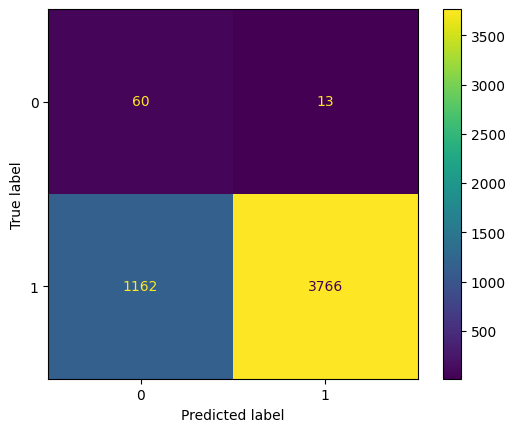

              precision    recall  f1-score   support

         0.0       0.05      0.82      0.09        73
         1.0       1.00      0.76      0.87      4928

    accuracy                           0.77      5001
   macro avg       0.52      0.79      0.48      5001
weighted avg       0.98      0.77      0.85      5001



In [9]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
test_x = np.concatenate((test_correct[:, stat_diff_layers], test_incorrect[:, stat_diff_layers]), axis=0)
test_y = np.concatenate((np.ones(test_correct.shape[0]), np.zeros(test_incorrect.shape[0])), axis=0)
conf_matrix = confusion_matrix(test_y, model.predict(test_x))
disp = ConfusionMatrixDisplay(conf_matrix)
disp.plot()
plt.show()
print(classification_report(test_y, model.predict(test_x)))

In [10]:
def apply_kdes(x, kdes):
  result = [] 
  for i, layer in enumerate(stat_diff_layers):
    print(f'Layer {i+1} of {len(stat_diff_layers)}')
    result.append(kdes[layer].score_samples(x[:, i][:, None]))
  return np.array(result).T
train_x_kde_incorrect = apply_kdes(train_x, incorrect_kdes)
train_x_kde_correct = apply_kdes(train_x, correct_kdes)
print(train_x_kde_incorrect.shape)
print(train_x_kde_correct.shape)

Layer 1 of 16
Layer 2 of 16
Layer 3 of 16
Layer 4 of 16
Layer 5 of 16
Layer 6 of 16
Layer 7 of 16
Layer 8 of 16
Layer 9 of 16
Layer 10 of 16
Layer 11 of 16
Layer 12 of 16
Layer 13 of 16
Layer 14 of 16
Layer 15 of 16
Layer 16 of 16
Layer 1 of 16
Layer 2 of 16
Layer 3 of 16
Layer 4 of 16
Layer 5 of 16
Layer 6 of 16
Layer 7 of 16
Layer 8 of 16
Layer 9 of 16
Layer 10 of 16
Layer 11 of 16
Layer 12 of 16
Layer 13 of 16
Layer 14 of 16
Layer 15 of 16
Layer 16 of 16
(20002, 16)
(20002, 16)


In [11]:
train_x_kde = np.concatenate((train_x_kde_incorrect, train_x_kde_correct), axis=1)

In [12]:
test_x_kde_incorrect = apply_kdes(test_x, incorrect_kdes)
test_x_kde_correct = apply_kdes(test_x, correct_kdes)


Layer 1 of 16
Layer 2 of 16
Layer 3 of 16
Layer 4 of 16
Layer 5 of 16
Layer 6 of 16
Layer 7 of 16
Layer 8 of 16
Layer 9 of 16
Layer 10 of 16
Layer 11 of 16
Layer 12 of 16
Layer 13 of 16
Layer 14 of 16
Layer 15 of 16
Layer 16 of 16
Layer 1 of 16
Layer 2 of 16
Layer 3 of 16
Layer 4 of 16
Layer 5 of 16
Layer 6 of 16
Layer 7 of 16
Layer 8 of 16
Layer 9 of 16
Layer 10 of 16
Layer 11 of 16
Layer 12 of 16
Layer 13 of 16
Layer 14 of 16
Layer 15 of 16
Layer 16 of 16


In [13]:
test_x_kde = np.concatenate((test_x_kde_incorrect, test_x_kde_correct), axis=1)

In [14]:
model = LogisticRegression(n_jobs=-1, fit_intercept=True, penalty=None, solver='saga',
                           class_weight='balanced', max_iter=1000)
model.fit(train_x_kde, train_y)

/home/rajpatel/Projects/llm-hallucination-monitoring/.venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


,penalty,None
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,'balanced'
,random_state,None
,solver,'saga'
,max_iter,1000
,multi_class,'deprecated'


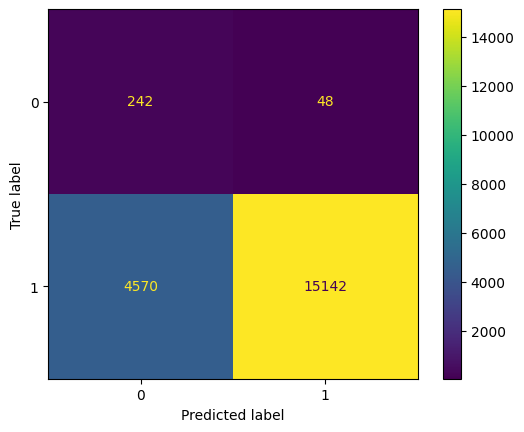

              precision    recall  f1-score   support

         0.0       0.05      0.83      0.09       290
         1.0       1.00      0.77      0.87     19712

    accuracy                           0.77     20002
   macro avg       0.52      0.80      0.48     20002
weighted avg       0.98      0.77      0.86     20002



In [15]:
# check if train data is overfit
conf_matrix = confusion_matrix(train_y, model.predict(train_x_kde))
disp = ConfusionMatrixDisplay(conf_matrix)
disp.plot()
plt.show()
print(classification_report(train_y, model.predict(train_x_kde)))

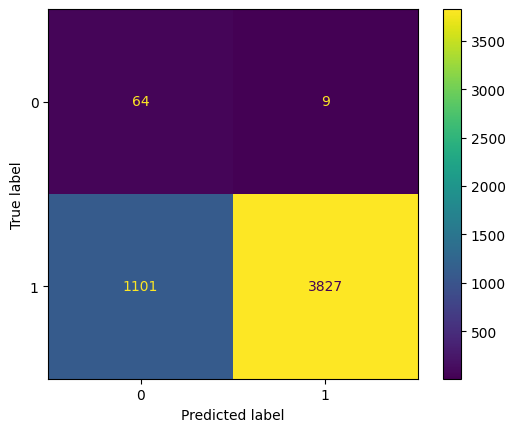

              precision    recall  f1-score   support

         0.0       0.05      0.88      0.10        73
         1.0       1.00      0.78      0.87      4928

    accuracy                           0.78      5001
   macro avg       0.53      0.83      0.49      5001
weighted avg       0.98      0.78      0.86      5001



In [16]:
# check performance on test data
conf_matrix = confusion_matrix(test_y, model.predict(test_x_kde))
disp = ConfusionMatrixDisplay(conf_matrix)
disp.plot()
plt.show()
print(classification_report(test_y, model.predict(test_x_kde)))

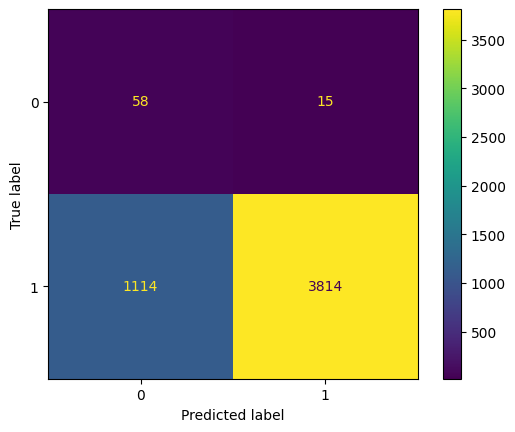

              precision    recall  f1-score   support

         0.0       0.05      0.79      0.09        73
         1.0       1.00      0.77      0.87      4928

    accuracy                           0.77      5001
   macro avg       0.52      0.78      0.48      5001
weighted avg       0.98      0.77      0.86      5001



In [17]:
# try mixture of expert models with balanced datasets
def train_logistic_regression(train_x, train_y):
    # get all indices of train_y where 0
    zero_indices = np.where(train_y == 0)[0]
    zero_subset_x = train_x[zero_indices]
    zero_subset_y = train_y[zero_indices]
    zero_sample_indices = np.random.choice(np.arange(zero_subset_x.shape[0]), 
                                       size=zero_subset_x.shape[0], replace=True)
    zero_sample_x = zero_subset_x[zero_sample_indices]
    zero_sample_y = zero_subset_y[zero_sample_indices]
    # get all indices of train_y where 1
    one_indices = np.where(train_y == 1)[0]
    one_subset_x = train_x[one_indices]
    one_subset_y = train_y[one_indices]
    # sample with replacement
    one_sample_indices = np.random.choice(np.arange(one_subset_x.shape[0]), 
                                       size=zero_subset_x.shape[0], replace=True)
    one_sample_x = one_subset_x[one_sample_indices] 
    one_sample_y = one_subset_y[one_sample_indices]
    x_sample = np.concatenate((zero_sample_x, one_sample_x), axis=0)
    y_sample = np.concatenate((zero_sample_y, one_sample_y), axis=0)
    model = LogisticRegression(n_jobs=-1, fit_intercept=True, penalty=None, solver='saga',
                               max_iter=5000)
    model.fit(x_sample, y_sample)
    return model

predictions = []
num_models = 100
for i in range(num_models):
    print(f'Training model {i+1} of {num_models}')
    print(f'Training on {len(train_x)} samples')
    model = train_logistic_regression(train_x, train_y)
    predictions.append(model.predict(test_x))
    clear_output(wait=True)
predictions = np.array(predictions)
predictions = np.mean(predictions, axis=0)
predictions = np.where(predictions > 0.5, 1, 0)
conf_matrix = confusion_matrix(test_y, predictions)
disp = ConfusionMatrixDisplay(conf_matrix)
disp.plot()
plt.show()
print(classification_report(test_y, predictions))

C: 0.0001, recall: 0.821917808219178
C: 0.001, recall: 0.7534246575342466
C: 0.01, recall: 0.684931506849315
C: 0.05, recall: 0.5753424657534246
C: 0.1, recall: 0.5205479452054794
Best C: 0.0001, Best recall: 0.821917808219178


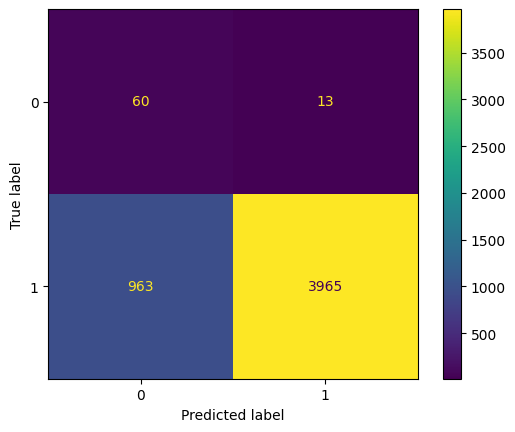

              precision    recall  f1-score   support

         0.0       0.06      0.82      0.11        73
         1.0       1.00      0.80      0.89      4928

    accuracy                           0.80      5001
   macro avg       0.53      0.81      0.50      5001
weighted avg       0.98      0.80      0.88      5001



In [57]:
# try svm
from sklearn.svm import SVC

best_C = 0.1
best_recall = 0
kernel = 'poly'
degree = 5
for C in [0.0001, 0.001, 0.01, 0.05, 0.1]:
    svc_model = SVC(class_weight='balanced', gamma='auto', C=C, kernel=kernel, degree=degree)
    svc_model.fit(train_x_kde, train_y)
    predictions = svc_model.predict(test_x_kde)
    metrics = classification_report(test_y, predictions, output_dict=True)
    recall = metrics['0.0']['recall']
    print(f'C: {C}, recall: {recall}')
    if recall > best_recall:
        best_C = C
        best_recall = recall

print(f'Best C: {best_C}, Best recall: {best_recall}')
svc_model = SVC(class_weight='balanced', gamma='auto', C=best_C, kernel=kernel, degree=degree)
svc_model.fit(train_x_kde, train_y)
predictions = svc_model.predict(test_x_kde)
conf_matrix = confusion_matrix(test_y, predictions)
disp = ConfusionMatrixDisplay(conf_matrix)
disp.plot()
plt.show()
print(classification_report(test_y, predictions))


C: 0.5, recall: 0.8767123287671232
C: 1.0, recall: 0.8767123287671232
C: 2.0, recall: 0.863013698630137
C: 5.0, recall: 0.821917808219178
C: 10.0, recall: 0.821917808219178
C: 20.0, recall: 0.821917808219178
C: 50.0, recall: 0.821917808219178
C: 100.0, recall: 0.821917808219178
C: 200.0, recall: 0.821917808219178
C: 500.0, recall: 0.821917808219178
C: 1000.0, recall: 0.821917808219178
Best C: 0.5, Best recall: 0.8767123287671232


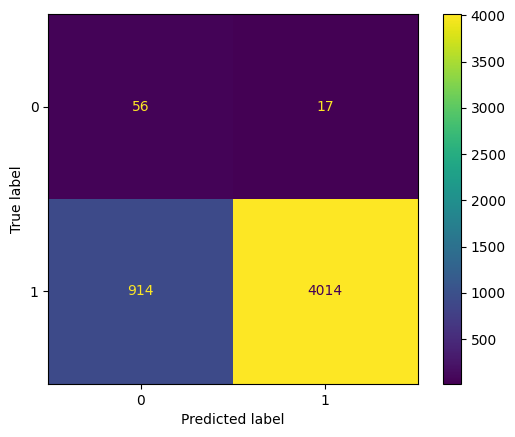

              precision    recall  f1-score   support

         0.0       0.06      0.77      0.11        73
         1.0       1.00      0.81      0.90      4928

    accuracy                           0.81      5001
   macro avg       0.53      0.79      0.50      5001
weighted avg       0.98      0.81      0.88      5001



In [ ]:
best_C = 0.5
best_recall = 0
kernel = 'poly'
for C in [0.5, 1., 2., 5., 10., 20., 50., 100., 200., 500., 1000.]:
    svc_model = SVC(class_weight='balanced', gamma='auto', C=C, kernel=kernel)
    svc_model.fit(train_x, train_y)
    predictions = svc_model.predict(test_x)
    metrics = classification_report(test_y, predictions, output_dict=True)
    recall = metrics['0.0']['recall']
    print(f'C: {C}, recall: {recall}')
    if recall > best_recall:
        best_C = C
        best_recall = recall
print(f'Best C: {best_C}, Best recall: {best_recall}')
svc_model = SVC(class_weight='balanced', gamma='auto', C=best_C, kernel=kernel)
svc_model.fit(train_x_kde, train_y)
predictions = svc_model.predict(test_x_kde)
conf_matrix = confusion_matrix(test_y, predictions)
disp = ConfusionMatrixDisplay(conf_matrix)
disp.plot()
plt.show()
print(classification_report(test_y, predictions))


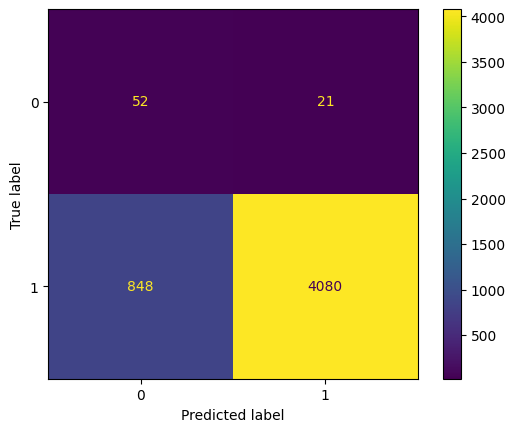

              precision    recall  f1-score   support

         0.0       0.06      0.71      0.11        73
         1.0       0.99      0.83      0.90      4928

    accuracy                           0.83      5001
   macro avg       0.53      0.77      0.51      5001
weighted avg       0.98      0.83      0.89      5001



In [67]:
# try mixture of expert models with balanced datasets
def train_svc(train_x, train_y, C):
    # get all indices of train_y where 0
    zero_indices = np.where(train_y == 0)[0]
    zero_subset_x = train_x[zero_indices]
    zero_subset_y = train_y[zero_indices]
    zero_sample_indices = np.random.choice(np.arange(zero_subset_x.shape[0]), 
                                       size=zero_subset_x.shape[0], replace=True)
    zero_sample_x = zero_subset_x[zero_sample_indices]
    zero_sample_y = zero_subset_y[zero_sample_indices]
    # get all indices of train_y where 1
    one_indices = np.where(train_y == 1)[0]
    one_subset_x = train_x[one_indices]
    one_subset_y = train_y[one_indices]
    # sample with replacement
    one_sample_indices = np.random.choice(np.arange(one_subset_x.shape[0]), 
                                       size=zero_subset_x.shape[0], replace=True)
    one_sample_x = one_subset_x[one_sample_indices] 
    one_sample_y = one_subset_y[one_sample_indices]
    x_sample = np.concatenate((zero_sample_x, one_sample_x), axis=0)
    y_sample = np.concatenate((zero_sample_y, one_sample_y), axis=0)
    model = SVC(gamma='auto', C=C, kernel='poly', degree=10)
    model.fit(x_sample, y_sample)
    return model

predictions = []
num_models = 500
for i in range(num_models):
    print(f'Training model {i+1} of {num_models}')
    model = train_svc(train_x_kde, train_y, C=100)
    predictions.append(model.predict(test_x_kde))
    clear_output(wait=True)
predictions = np.array(predictions)
predictions = np.mean(predictions, axis=0)
predictions = np.where(predictions > 0.5, 1, 0)
conf_matrix = confusion_matrix(test_y, predictions)
disp = ConfusionMatrixDisplay(conf_matrix)
disp.plot()
plt.show()
print(classification_report(test_y, predictions))

In [ ]:
# try random forest or xgboost
# or thresholding the kde scores

# *MISCELLANEOUS CODE: NOT FINALIZED*
Anything below this are just random plots I've made, don't trust them.

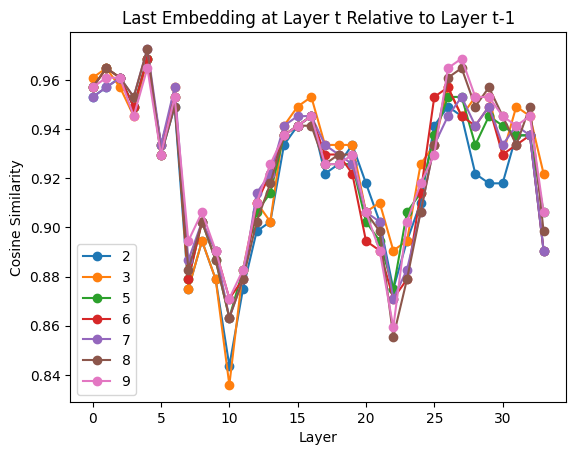

In [ ]:
nums = ['1', '2', '3', '4', '5', '6', '7', '8']
data = {}
for num in nums:
  message = f'The sum of 1 and {num} equals '
  predicted_token, cos_sims = generate_cos_sims_for_token(message, model, tokenizer,
                                                          vector_pos=-1)
  data[predicted_token] = cos_sims

for num, cos_sims in data.items():
  plt.errorbar(range(len(cos_sims)), cos_sims,
               label=num, marker='o', capsize=4)
plt.xlabel('Layer')
plt.ylabel('Cosine Similarity')
plt.legend()
plt.title('Last Embedding at Layer t Relative to Layer t-1')
plt.show()

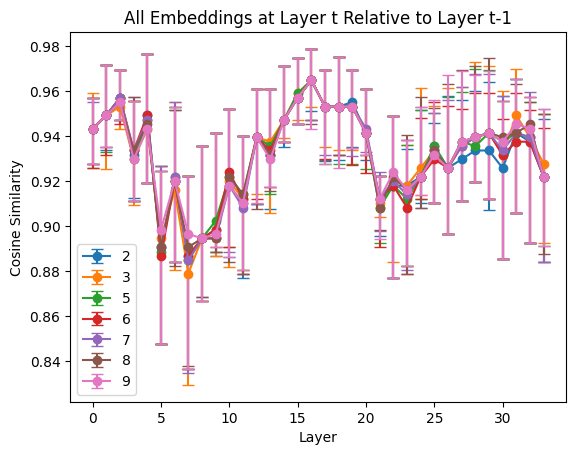

In [ ]:
nums = ['1', '2', '3', '4', '5', '6', '7', '8']
data = {}
for num in nums:
  message = f'The sum of 1 and {num} equals '
  predicted_token, cos_sims = generate_cos_sims_for_token(message, model, tokenizer,
                                                          vector_pos='all')
  cos_sims = np.array(cos_sims)
  cos_sims_stats = get_statistics(cos_sims, axis=0)
  data[predicted_token] = cos_sims_stats

for num, stats in data.items():
  plt.errorbar(range(stats['shape'][1]), stats['median'],
               yerr=np.array([stats['median'] - stats['p16'], stats['p84'] - stats['median']]),
               label=num, marker='o', capsize=4)
plt.xlabel('Layer')
plt.ylabel('Cosine Similarity')
plt.legend()
plt.title('All Embeddings at Layer t Relative to Layer t-1')
plt.show()

Note that in the plot above, the model incorrectly predicts 1 + 3 = 2, which is why there is no entry for 4.
This means the line for 2 corresponds to a hallucination.

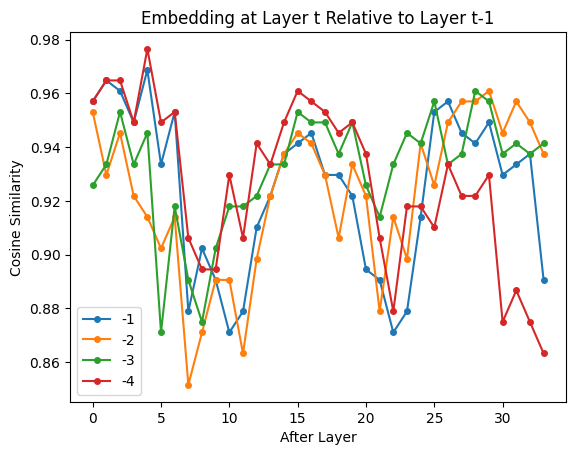

In [ ]:
message = f'The sum of 1 and 5 equals '
for i in range(-1, -5, -1):
  predicted_word, cos_sims = generate_plot_for_word(message, model, tokenizer,
                                                    plot=False, vector_pos=i)
  plt.plot(range(len(cos_sims)), cos_sims, label=i, marker='o', markersize=4)
plt.xlabel('After Layer')
plt.ylabel('Cosine Similarity')
plt.title('Embedding at Layer t Relative to Layer t-1')
plt.legend()
plt.show()

Text(0, 0.5, 'Amplitude')

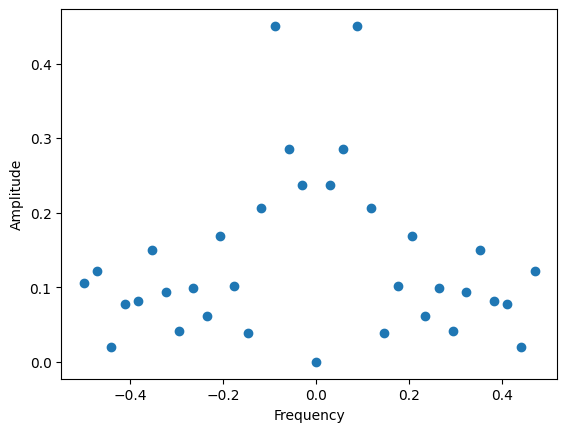

In [ ]:
signal = cos_sims[1:-1] - np.mean(cos_sims[1:-1])
fourier_trans = np.fft.fft(signal)
frequencies = np.fft.fftfreq(len(signal), 1)
plt.scatter(frequencies, np.abs(fourier_trans))
plt.xlabel('Frequency')
plt.ylabel('Amplitude')

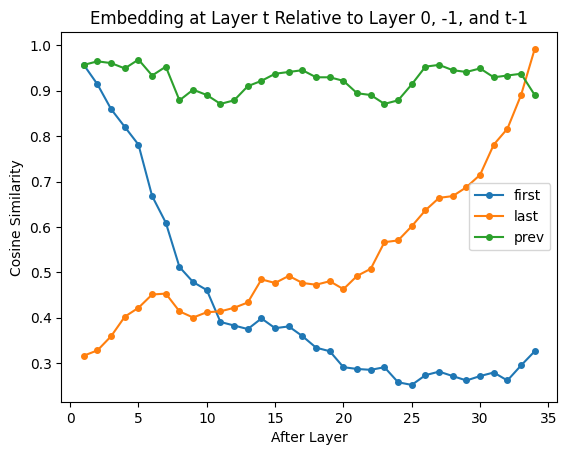

In [ ]:
message = f'The sum of 1 and 5 equals '

predicted_word, cos_sims = generate_plot_for_word(message, model, tokenizer,
                                                  plot=False, comp='first')
plt.plot(range(1, len(cos_sims)+1), cos_sims,
         label='first', marker='o', markersize=4)

predicted_word, cos_sims = generate_plot_for_word(message, model, tokenizer,
                                                  plot=False, comp='last')
plt.plot(range(1, len(cos_sims)+1), cos_sims,
         label='last', marker='o', markersize=4)

predicted_word, cos_sims = generate_plot_for_word(message, model, tokenizer,
                                                  plot=False, comp='prev')
plt.plot(range(1, len(cos_sims)+1), cos_sims,
         label='prev', marker='o', markersize=4)

plt.xlabel('After Layer')
plt.ylabel('Cosine Similarity')
plt.legend(loc='center right')
plt.title('Embedding at Layer t Relative to Layer 0, -1, and t-1')
plt.show()

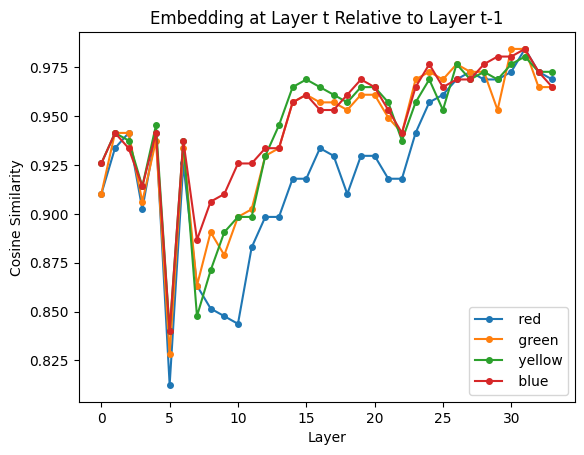

In [ ]:
messages = ['the color of a fire truck is', 'the color of grass is',
            'the color of the sun is', 'the color of the sky is']
color_sims = {}
for message in messages:
  inputs = tokenizer(message, return_tensors="pt").to(model.device)
  generated = model(**inputs, max_new_tokens=100, output_hidden_states=True)
  predicted_color = get_next_word(generated.hidden_states, model, tokenizer)
  cos_sims = calc_sims(generated.hidden_states)
  color_sims[predicted_color] = cos_sims

for color, cos_sims in color_sims.items():
  plt.plot(range(len(cos_sims)), cos_sims, label=color, marker='o', markersize=4)
plt.xlabel('Layer')
plt.ylabel('Cosine Similarity')
plt.legend()
plt.title('Embedding at Layer t Relative to Layer t-1')
plt.show()

 yellow
 yellow


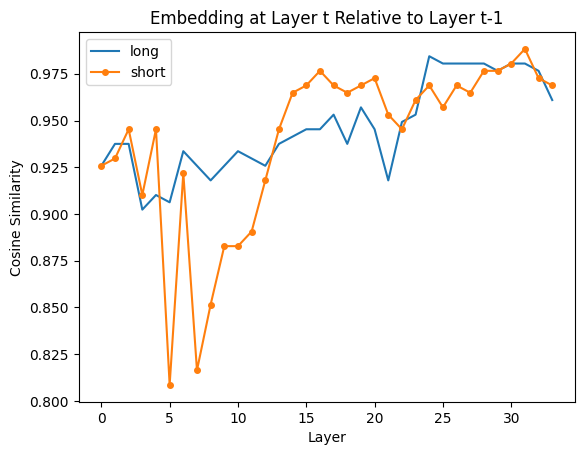

In [ ]:
message = 'I was walking down the street and I was astounded by how blue the sky looked. ' +\
 'Unusually, I saw a yellow fire truck on the way. ' +\
 'I stopped at the park to enjoy some greenery and then I went home. ' +\
 'My friend asked me I saw today. ' +\
 'I said that I saw a fire truck that was'
predicted_word, cos_sims = generate_plot_for_word(message, model, tokenizer, plot=False)
print(predicted_word)
plt.plot(range(len(cos_sims)), cos_sims, label='long')

message = 'The color of the sun is'
predicted_word, cos_sims = generate_plot_for_word(message, model, tokenizer, plot=False)
print(predicted_word)
plt.plot(range(len(cos_sims)), cos_sims, label='short', marker='o', markersize=4)

plt.xlabel('Layer')
plt.ylabel('Cosine Similarity')
plt.title('Embedding at Layer t Relative to Layer t-1')
plt.legend()
plt.show()

8
8
8
8


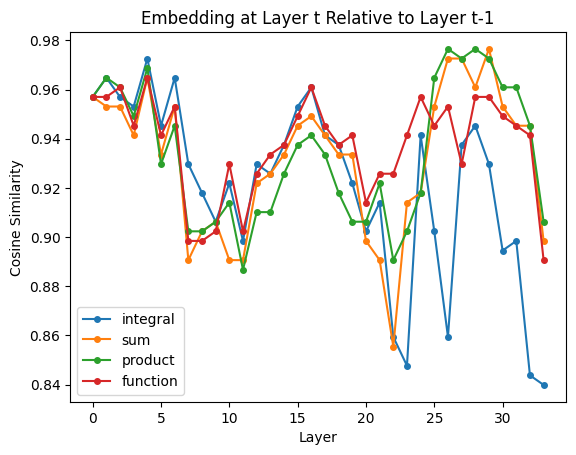

In [ ]:
message = 'The integral of 3 times x squared from 0 to 2 equals '
predicted_word, cos_sims = generate_plot_for_word(message, model, tokenizer, plot=False)
print(predicted_word)
plt.plot(range(len(cos_sims)), cos_sims, label='integral', marker='o', markersize=4)

message = 'The sum of 5 and 3 equals '
predicted_word, cos_sims = generate_plot_for_word(message, model, tokenizer, plot=False)
print(predicted_word)
plt.plot(range(len(cos_sims)), cos_sims, label='sum', marker='o', markersize=4)

message = 'The product of 4 and 2 equals '
predicted_word, cos_sims = generate_plot_for_word(message, model, tokenizer, plot=False)
print(predicted_word)
plt.plot(range(len(cos_sims)), cos_sims, label='product', marker='o', markersize=4)

message = 'The value of y = x^3 where x = 2 equals '
predicted_word, cos_sims = generate_plot_for_word(message, model, tokenizer, plot=False)
print(predicted_word)
plt.plot(range(len(cos_sims)), cos_sims, label='function', marker='o', markersize=4)

plt.xlabel('Layer')
plt.ylabel('Cosine Similarity')
plt.title('Embedding at Layer t Relative to Layer t-1')
plt.legend()
plt.show()

In [ ]:
message = ' two'
inputs = tokenizer(message, return_tensors="pt").to(model.device)
print(torchinfo.summary(model, input_data=inputs.input_ids, device='cuda'))

Layer (type:depth-idx)                        Output Shape              Param #
Qwen3ForCausalLM                              --                        --
├─Qwen3Model: 1-1                             --                        --
│    └─Embedding: 2-1                         [1, 1, 2560]              388,956,160
│    └─Qwen3RotaryEmbedding: 2-2              [1, 1, 128]               --
│    └─ModuleList: 2-3                        --                        --
│    │    └─Qwen3DecoderLayer: 3-1            [1, 1, 2560]              100,930,816
│    │    └─Qwen3DecoderLayer: 3-2            [1, 1, 2560]              100,930,816
│    │    └─Qwen3DecoderLayer: 3-3            [1, 1, 2560]              100,930,816
│    │    └─Qwen3DecoderLayer: 3-4            [1, 1, 2560]              100,930,816
│    │    └─Qwen3DecoderLayer: 3-5            [1, 1, 2560]              100,930,816
│    │    └─Qwen3DecoderLayer: 3-6            [1, 1, 2560]              100,930,816
│    │    └─Qwen3DecoderLayer: 3